In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
import datetime
import smogn

# Outline
1. Reading the Data
2. Missing Values
3. EDA
4. Feature Engineering
5. Model Building and Evaluation Part 1 - Direct approch
6. Model Building and Evaluation Part 2 - Over-sampling

# 1. Reading the Data

In [2]:
train = pd.read_csv('Train.csv')

In [3]:
print('Shape of df :',train.shape)
train.head()

Shape of df : (284780, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35


# Meta-data
1. "InvoiceNo" - Invoice ID, encoded as Label

2. "StockCode" - Unique code per stock, encoded as Label

3. "Description" - The Description, encoded as Label

4. "Quantity" - Quantity purchased

5. "InvoiceDate" - Date of purchase which was filtered into circular coordinates as follows:
    - year
    - month_sin, month_cos
    - day_sin,day_cos
    - hour_sin, hour_cos
    - minute_sin, minute_cos
                 
6. "UnitPrice" - The target value, price of every product

7. "CustomerID" - Unique Identifier for every Customer

8. "Country" - Country of sales, encoded as Label

# 2. Missing values

In [4]:
print('Missing values : ','\n', train.isnull().sum())

Missing values :  
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


# 3. EDA

In [5]:
train.describe()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
count,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000
mean,9955.394083,1573.386807,2023.955573,12.028468,3.451216,15288.224278,32.823846
std,5551.519138,843.604991,1089.812078,295.111588,78.399541,1714.336529,6.743602
min,0.000000,0.000000,0.000000,-80995.000000,0.000000,12346.000000,0.000000
25%,5069.000000,939.000000,1141.000000,2.000000,1.250000,13953.000000,35.000000
50%,10310.000000,1521.000000,1987.000000,5.000000,1.950000,15152.000000,35.000000
75%,14657.000000,2106.000000,2945.000000,12.000000,3.750000,16794.000000,35.000000
max,22188.000000,3683.000000,3895.000000,80995.000000,38970.000000,18287.000000,36.000000


In [6]:
# Top 5 UnitPrice
train.sort_values('UnitPrice',ascending = False).head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
140723,20237,3681,2140,-1,2011-06-10 15:31:00,38970.00,15098.0,35
239556,19848,3683,2624,-1,2011-05-03 12:51:00,8142.75,16029.0,35
266800,14826,3681,2140,1,2011-10-27 14:20:00,4161.06,12536.0,13
113566,21589,3681,2140,-2,2011-10-27 14:15:00,4161.06,12536.0,13
51127,14824,3681,2140,1,2011-10-27 14:13:00,4161.06,12536.0,13


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

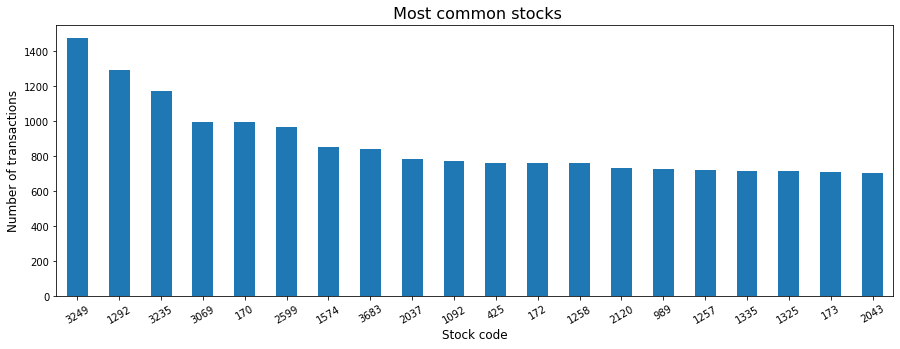

In [7]:
# Most commom Stocks
plt.figure(figsize=(15,5))
train.StockCode.value_counts()[:20].plot(kind = 'bar')
plt.title(' Most common stocks',fontsize = 16)
plt.xlabel('Stock code',fontsize = 12)
plt.ylabel('Number of transactions',fontsize = 12)
plt.xticks(rotation = 30)

Text(0.5, 1.0, 'Most Expensive Transacitons')

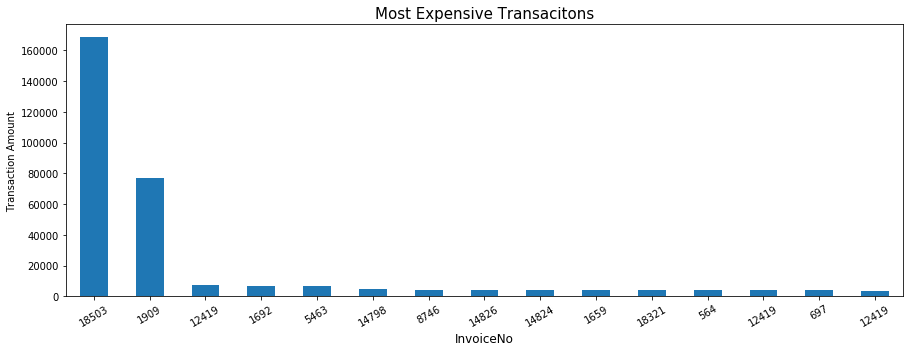

In [8]:
# Most Expensive transactions
train_plot = train.copy()
train_plot['total price'] = train.UnitPrice * train.Quantity

plt.figure(figsize = (15,5))
train_plot = train_plot.sort_values(by = 'total price', ascending=False)
train_plot.iloc[:15,:].set_index('InvoiceNo')['total price'].plot(kind='bar')
plt.xlabel('InvoiceNo',fontsize=12)
plt.xticks(rotation = 30)
plt.ylabel('Transaction Amount')
plt.title('Most Expensive Transacitons', fontsize = 15)

Text(0.5, 0, 'Month')

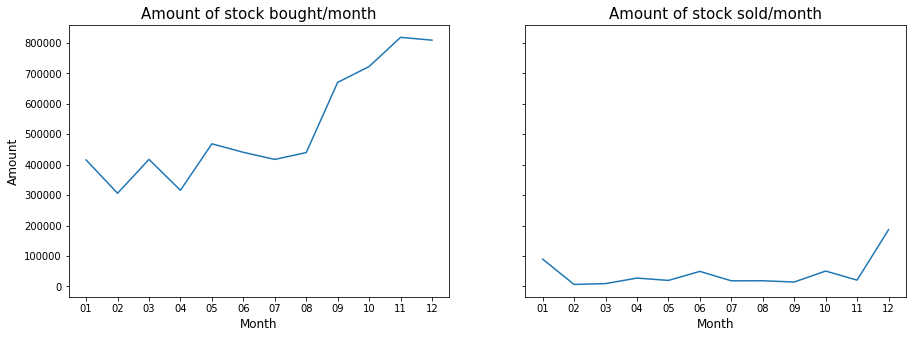

In [9]:
# Monthly stock activity
train_plot['abs_total price'] = train_plot['total price'].apply(lambda x : np.abs(x))
train_plot['month'] = train_plot.InvoiceDate.apply(lambda x: x.split('-')[1])

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
ax1.plot(train_plot[train_plot['total price'] > 0].groupby('month')['abs_total price'].sum())
ax1.set_title('Amount of stock bought/month',fontsize = 15)
ax1.set_ylabel('Amount', fontsize = 12)
ax1.set_xlabel('Month',fontsize = 12)
ax2.plot(train_plot[train_plot['total price'] < 0].groupby('month')['abs_total price'].sum())
ax2.set_title('Amount of stock sold/month',fontsize = 15)
ax2.set_xlabel('Month',fontsize = 12)

Text(0, 0.5, 'Number of Transactions')

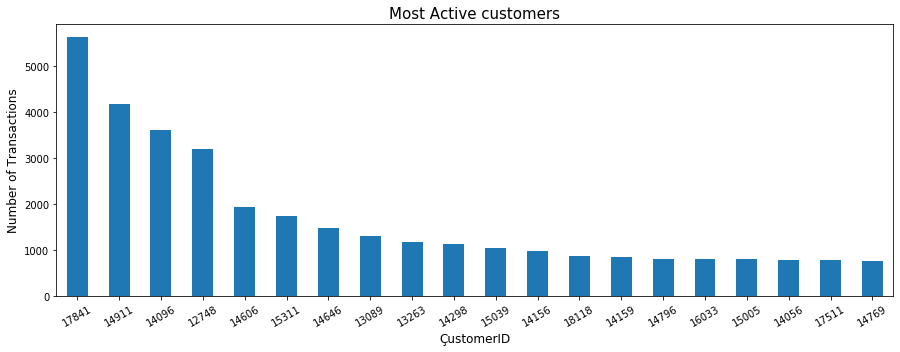

In [10]:
plt.figure(figsize = (15,5))
train_plot.CustomerID.apply(lambda x:int(x)).value_counts().iloc[:20].plot(kind = 'bar')
plt.xticks(rotation = 30)
plt.title('Most Active customers', fontsize = 15)
plt.xlabel('ÇustomerID', fontsize = 12)
plt.ylabel('Number of Transactions', fontsize = 12)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

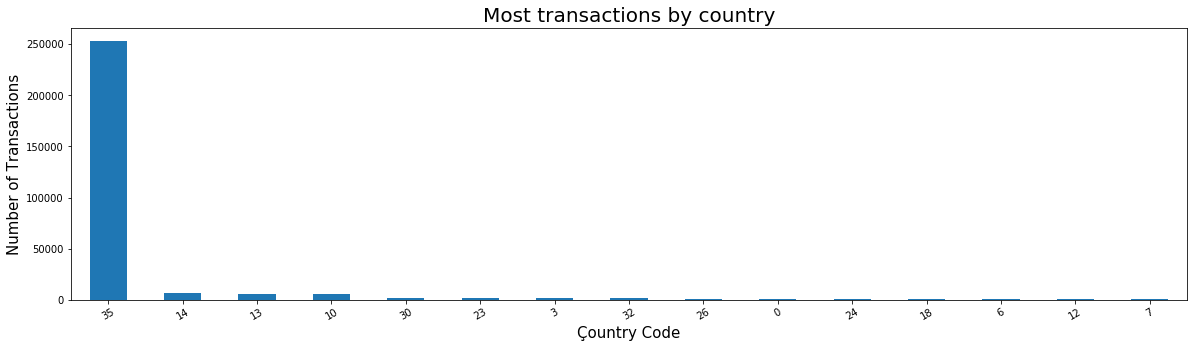

In [11]:
# Most transactions by country
plt.figure(figsize=(20,5))
x = train_plot.Country.value_counts(sort = True,ascending = False)[:15].index.tolist()
y = train_plot.Country.value_counts(sort = True,ascending = False)[:15].values.tolist()
train_plot.Country.value_counts(sort = True,ascending = False)[:15].plot(kind='bar')
plt.ylabel('Number of Transactions',fontsize=15)
plt.xlabel('Çountry Code',fontsize=15)
plt.title('Most transactions by country',fontsize=20)
plt.xticks(rotation=30)



Text(0.5, 1.0, 'Net cash Flow by month')

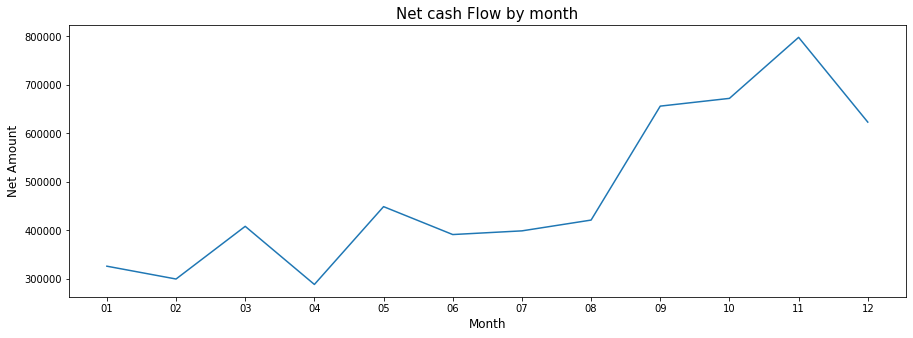

In [12]:
plt.figure(figsize = (15,5))
sns.lineplot(train_plot.groupby('month')['total price'].sum().index,train_plot.groupby('month')['total price'].sum().values)
plt.xlabel("Month", fontsize = 12)
plt.ylabel("Net Amount", fontsize = 12)
plt.title('Net cash Flow by month', fontsize = 15)

## Key Take-aways from EDA
1. A major part of overall market trade took place towards the end of year (Nov-Dec).
2. There is always a net cash inflow which peaked in november, whereas april had lowest cash inflow.
3. Most number of transactions were done by customers present in Country code 35.

# 4. Feature Engineering

In [13]:
# Convert to Datetime format
train.InvoiceDate = pd.to_datetime(train.InvoiceDate)

In [14]:
# Creating Backup
train2 = train.copy()

In [15]:
# Extract date & time of transaction
train2['year'] = train2.InvoiceDate.apply(lambda x : x.year)
train2['month'] = train2.InvoiceDate.apply(lambda x : x.month)
train2['day'] = train2.InvoiceDate.apply(lambda x : x.day)
train2['hour'] = train2.InvoiceDate.apply(lambda x : x.hour)
train2['minute'] = train2.InvoiceDate.apply(lambda x : x.minute)

# Drop existing date column
train2.drop('InvoiceDate', axis = 1, inplace = True)

In [16]:
# converting to circular coordinates 
train3 = train2.copy()
train3['month_sin'] = np.sin((train3.month-1)*(2.*np.pi/12))
train3['month_cos'] = np.cos((train3.month-1)*(2.*np.pi/12))

train3['day_sin'] = np.sin((train3.day-1)*(2.*np.pi/12))
train3['day_cos'] = np.cos((train3.day-1)*(2.*np.pi/12))

train3['hour_sin'] = np.sin((train3.hour-1)*(2.*np.pi/12))
train3['hour_cos'] = np.cos((train3.hour-1)*(2.*np.pi/12))

train3['minute_sin'] = np.sin((train3.minute-1)*(2.*np.pi/12))
train3['minute_cos'] = np.cos((train3.minute-1)*(2.*np.pi/12))

train3.drop(['month', 'hour', 'minute', 'day'], axis = 1, inplace = True)

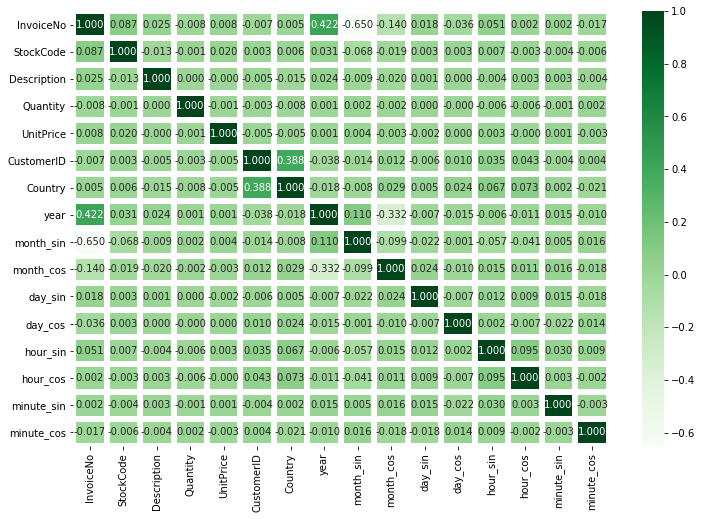

In [17]:
# Correlation heatmap
plt.figure(figsize = (12,8))
sns.heatmap(train3.corr(), cmap ='Greens', lw = 5, annot = True, fmt = '.3f', alpha = 1)

# 5. Model Building and Evaluation Part 1 - Direct approch

In [18]:
# Split features and target
X1 = train3.drop(['UnitPrice'], axis = 1)
y1 = train3.UnitPrice.copy()

# standardize the features
ss= StandardScaler()
X1 = ss.fit_transform(X1)

In [19]:
#Cross validation
lr = LinearRegression()
rf = RandomForestRegressor(n_jobs=-1)
xgb = XGBRegressor()
ri = Ridge()
la = Lasso()

print('Cross validation mean RMSE score')
lr_cv = cross_val_score(lr,X1,y1,cv = 10, scoring = 'neg_root_mean_squared_error').mean()
print('For Linear Regression : ',round(-1*lr_cv,3))

lr_rf = cross_val_score(rf,X1,y1,cv = 8, scoring = 'neg_root_mean_squared_error').mean()
print('For Random Forest : ',round(-1*lr_rf,3))

lr_xgb = cross_val_score(xgb,X1,y1,cv = 8, scoring = 'neg_root_mean_squared_error').mean()
print('For XGBoost : ',round(-1*lr_xgb,3))

ri_cv = cross_val_score(ri,X1,y1,cv = 8, scoring = 'neg_root_mean_squared_error').mean()
print('For Ridge : ',round(-1*ri_cv,3))

la_cv = cross_val_score(la,X1,y1,cv = 8, scoring = 'neg_root_mean_squared_error').mean()
print('For Lasso : ',round(-1*la_cv,3))

Cross validation mean RMSE score
For Linear Regression :  47.3
For Random Forest :  63.127
For XGBoost :  71.812
For Ridge :  48.718
For Lasso :  48.711


# 6. Model Building and Evaluation Part 2 - Over sampling

In [20]:
# oversampling
# separateing minority & majority values
train3_maj = train3[train3.UnitPrice < train3.UnitPrice.quantile(0.75)]
train3_min= train3[train3.UnitPrice > train3.UnitPrice.quantile(0.75)]

# oversample minority values
train3_min_oversampled = train3_min.sample(train3_maj.shape[0], replace = True, random_state = 10)

# combining majority values with over-sampled minority values
balanced_df = pd.concat([train3_maj, train3_min_oversampled], ignore_index = True)

# Shuffle the over-sampled DataFrame
balanced_df = balanced_df.sample(frac = 1)
balanced_df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos
370799,5357,1893,2683,2,8.25,12769.0,4,2011,1.000000,6.123234e-17,8.660254e-01,0.500000,-1.000000e+00,-1.836970e-16,-4.898587e-16,1.000000e+00
108827,2089,1597,1991,18,2.95,12625.0,14,2011,0.000000,1.000000e+00,-5.000000e-01,0.866025,-2.449294e-16,1.000000e+00,8.660254e-01,5.000000e-01
55903,6535,2956,1273,2,2.95,15529.0,35,2011,0.866025,-5.000000e-01,-2.449294e-16,1.000000,-8.660254e-01,5.000000e-01,-8.660254e-01,-5.000000e-01
215777,16618,3146,702,24,4.15,12406.0,9,2011,-0.866025,5.000000e-01,8.660254e-01,-0.500000,3.673940e-16,-1.000000e+00,-1.000000e+00,-4.286264e-16
211430,7359,1629,3398,1,9.95,18232.0,35,2011,0.866025,-5.000000e-01,2.388680e-15,-1.000000,-5.000000e-01,-8.660254e-01,8.660254e-01,5.000000e-01


In [21]:
# Split oversampled data
Xnew = balanced_df.drop(['UnitPrice'], axis = 1)
ynew = balanced_df.UnitPrice.copy()

# standardize the features
ss1 = StandardScaler()
Xnew = ss1.fit_transform(Xnew)

In [22]:
#Cross validation after over-sampling
lr = LinearRegression()
rf = RandomForestRegressor(n_jobs=-1)
xgb = XGBRegressor()
ri = Ridge()
la = Lasso()

print('Cross validation mean RMSE score')
lr_cv = cross_val_score(lr,Xnew,ynew,cv =5, scoring = 'neg_root_mean_squared_error').mean()
print('For Linear Regression : ',round(-1*lr_cv,3))

lr_rf = cross_val_score(rf,Xnew,ynew,cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print('For RandomForest : ',round(-1*lr_rf,3))

lr_xgb = cross_val_score(xgb,Xnew,ynew,cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print('For XGBoost : ',round(-1*lr_xgb,3))

ri_cv = cross_val_score(ri,Xnew,ynew,cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print('For Ridge : ',round(-1*ri_cv,3))

la_cv = cross_val_score(la,Xnew,ynew,cv = 5, scoring = 'neg_root_mean_squared_error').mean()
print('For Lasso : ',round(-1*la_cv,3))

Cross validation mean RMSE score
For Linear Regression :  101.984
For RandomForest :  35.561
For XGBoost :  24.15
For Ridge :  101.984
For Lasso :  102.026


# Key Take-aways from Over-sampling
Tree based model performance improved whereas linear models performance went down as before oversampling linear models where fitting the minority class properly.

In [23]:
# XGB Hyperparameter Tuning as XGBoost has the best cross-validation result
xgb_new = XGBRegressor()

# Paramete Grid
grid = {
    'max_depth' : [12],
    'min_child_weight' : [1],
    'n_estimators' : [450],
    'gamma' : [0],
    'subsample':[1],'colsample_bytree':[1],
    'reg_alpha':[0.01],
    'learning_rate' : [0.3]
}

# Grid Search
gsnew = GridSearchCV(xgb_new, grid, n_jobs=-1, verbose=2,scoring='neg_root_mean_squared_error')
gsnew.fit(Xnew,ynew)

print('Best Hyper-parameter tuning parameters : ',gsnew.best_params_)
print('Best Score obtained from GridSearchCV : ',-1*gsnew.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.6min finished


Best Hyper-parameter tuning parameters :  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 450, 'reg_alpha': 0.01, 'subsample': 1}
Best Score obtained from GridSearchCV :  13.59441834387215


In [24]:
# best model
xgb=XGBRegressor(max_depth = 12, min_child_weight = 1, n_estimators = 450, gamma = 0, subsample = 1,
                 colsample_bytree = 1, reg_alpha = 0.01, learning_rate = 0.3)
xgb.fit(Xnew,ynew)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=450, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

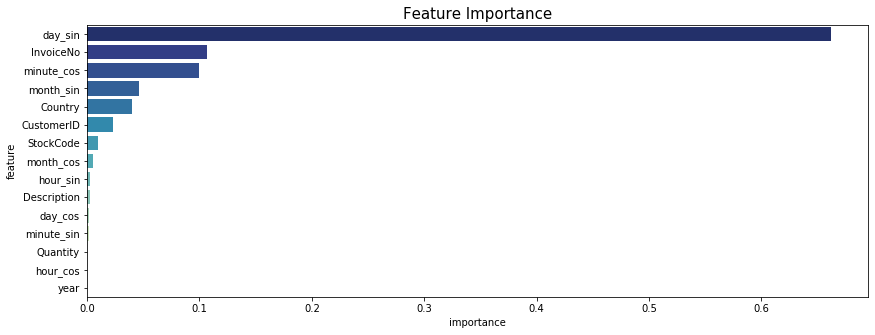

In [25]:
# Most important Features
feature_imp = pd.DataFrame()
feature_imp['feature'] = balanced_df.drop(['UnitPrice'], axis = 1).columns
feature_imp['importance'] = xgb.feature_importances_
feature_imp = feature_imp.sort_values(by = 'importance', ascending = False)


plt.figure(figsize = (14,5))
sns.barplot(x = feature_imp.importance , y = feature_imp.feature, palette = 'YlGnBu_r')
plt.title('Feature Importance',fontsize = 15)
plt.show()

In [26]:
# Model evaluation
xtrain,xtest,ytrain,ytest = train_test_split(Xnew, ynew, random_state = 5, test_size = 0.2)

xgb_test = xgb
test_pred = xgb_test.fit(xtrain,ytrain).predict(xtest)
rmse_test = np.sqrt(mean_squared_error(ytest, test_pred))
r2_test = r2_score(ytest, test_pred)
print('RMSE = ', round(rmse_test,2), '& r2 = ', round(r2_test,2))

RMSE =  12.22 & r2 =  0.99


In [27]:
# Import testing data
test = pd.read_csv('Test.csv')

# Extract date time in required format
test.InvoiceDate = pd.to_datetime(test.InvoiceDate)
test['year'] = test.InvoiceDate.apply(lambda x : x.year)
test['month'] = test.InvoiceDate.apply(lambda x : x.month)
test['day'] = test.InvoiceDate.apply(lambda x : x.day)
test['hour'] = test.InvoiceDate.apply(lambda x : x.hour)
test['minute'] = test.InvoiceDate.apply(lambda x : x.minute)
test.drop('InvoiceDate', axis = 1, inplace = True)

test['month_sin'] = np.sin((test.month-1)*(2.*np.pi/12))
test['month_cos'] = np.cos((test.month-1)*(2.*np.pi/12))

test['day_sin'] = np.sin((test.day-1)*(2.*np.pi/12))
test['day_cos'] = np.cos((test.day-1)*(2.*np.pi/12))

test['hour_sin'] = np.sin((test.hour-1)*(2.*np.pi/12))
test['hour_cos'] = np.cos((test.hour-1)*(2.*np.pi/12))

test['minute_sin'] = np.sin((test.minute-1)*(2.*np.pi/12))
test['minute_cos'] = np.cos((test.minute-1)*(2.*np.pi/12))

test.drop(['month', 'hour', 'minute', 'day'], axis = 1, inplace = True)

# standardize the values
test = ss.fit_transform(test)

In [28]:
# make prediction for testing data
result = xgb.predict(test)

In [29]:
# Export predictions
sub = pd.DataFrame({'UnitPrice':result})
#sub.to_csv('sub.csv', index = False)

# Conclusions
1. Over-sampling of data resulted in tremendous performance enhancement for tree based models. XGBoost was selected finally as it performed better than RandomForest in RMSE score & R2 Score as well.
2. Hyper-parameter tuning of XGBoost was performed successfully. After tuning, there was round 35% reduction in RMSE score.
3. I will re-build the model in future and try to achieve much better performance.
4. The next iteration of this project and notebook, may include time series analysis, to see if we can predict future Stock price accurately.